# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

# Solving the Tennis UnityEnvironment with 2 ddpg players

In [1]:
# Parallel Training ####

from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")#, no_graphics = True)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])




%load_ext autoreload
%autoreload 2

import torch
from matplotlib import pyplot as plt
from ddpg_agent import Agent
from collections import deque

env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]



print_every = 30
n_episodes= 500 #4000 # 2000
max_t=1000
Batch_size = 128# 512
N_Bootstrap = 4  ## New
Learning_Rate = 4 #10
seed = 0

LR_actor = 1e-3  #4        # learning rate of the actor 
LR_critic = 1e-3        # learning rate of the critic
gamma = 0.99#0.99            # discount factor

#priorized replay
prio_epsilon = 0.001
prio_beta = .8
prio_exponent = .8

# noise
theta = .03
sigma = .04
def ddpg(env, agents, print_every, n_episodes, max_t, Batch_size, N_Bootstrap, seed):
    scores_deque = deque(maxlen=print_every)
    all_scores = []
    for i_episode in range(0, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        for agent in agents:
            agent.reset()
        states = env_info.vector_observations
        scores = np.asarray([0.,0.])
        reduction = 2. #((n_episodes-i_episode+0.0)/(n_episodes+0.0))**3.
        noise_down = 0.9999
        for t in range(max_t):
            reduction *= noise_down
            actions = [agents[i].act(states[i],reduction) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += np.asarray(env_info.rewards)
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            states = next_states
            if np.any(dones):
                break
        avg_score = np.max(scores) 
        #print (scores)
        scores_deque.append(avg_score)
        all_scores.append(avg_score)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            print (len(agent.memory.prios))
            print (max(agent.memory.prios))
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-print_every, np.mean(scores_deque)))
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor_agent0'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic_agent0'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_agent1'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_agent1'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            
    return all_scores
score_table = []
for N_Bootstrap in [4,1]:
    for prio in [0.8,0.]:
        for seed in range(3):
            print ("N_Bootstrap")
            print (N_Bootstrap)
            print ("seed")
            print (seed)
            print ("prio")
            print (prio)
            agents = [Agent(state_size, action_size, seed, Batch_size, Learning_Rate, N_Bootstrap, LR_actor, LR_critic, gamma, theta, sigma, prio, prio, prio_epsilon) for _ in range(num_agents)]
            all_scores = ddpg(env, agents, print_every, n_episodes, max_t, Batch_size, N_Bootstrap, seed)
            score_table.append(all_scores)
            print ("score")
            print (max(all_scores))
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor_agent0'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic_agent0'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_agent1'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_agent1'+str(seed)+ "_" + str(N_Bootstrap) +"_"+ str(prio)+".pth")
                        
            

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
N_Bootstrap
4
seed
0
prio
0.8
Episode 0	Average Score: 0.0000
14
0.07244645601511002


/home/oliver/.local/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 30	Average Score: 0.0067
477
0.03272761031985283
Episode 60	Average Score: 0.0197
1021
0.03847460076212883
Episode 90	Average Score: 0.0283
1642
0.044690167367458344
Episode 120	Average Score: 0.0720
2648
0.0704820528626442
Episode 150	Average Score: 0.0967
3824
0.10864820331335068
Episode 180	Average Score: 0.1217
5366
0.14947903156280518
Episode 210	Average Score: 0.3727
9926
0.3483369052410126

Environment solved in 191 episodes!	Average Score: 0.52

Environment solved in 192 episodes!	Average Score: 0.52

Environment solved in 193 episodes!	Average Score: 0.52

Environment solved in 194 episodes!	Average Score: 0.53

Environment solved in 195 episodes!	Average Score: 0.52

Environment solved in 196 episodes!	Average Score: 0.56

Environment solved in 197 episodes!	Average Score: 0.58

Environment solved in 198 episodes!	Average Score: 0.62

Environment solved in 199 episodes!	Average Score: 0.70

Environment solved in 200 episodes!	Average Score: 0.67

Environment solved in


Environment solved in 350 episodes!	Average Score: 1.44

Environment solved in 351 episodes!	Average Score: 1.50

Environment solved in 352 episodes!	Average Score: 1.46

Environment solved in 353 episodes!	Average Score: 1.48

Environment solved in 354 episodes!	Average Score: 1.44

Environment solved in 355 episodes!	Average Score: 1.44

Environment solved in 356 episodes!	Average Score: 1.43

Environment solved in 357 episodes!	Average Score: 1.43

Environment solved in 358 episodes!	Average Score: 1.37

Environment solved in 359 episodes!	Average Score: 1.37
Episode 390	Average Score: 1.3827
77160
1254.0748291015625

Environment solved in 360 episodes!	Average Score: 1.38

Environment solved in 361 episodes!	Average Score: 1.39

Environment solved in 362 episodes!	Average Score: 1.31

Environment solved in 363 episodes!	Average Score: 1.24

Environment solved in 364 episodes!	Average Score: 1.25

Environment solved in 365 episodes!	Average Score: 1.24

Environment solved in 366 ep

Episode 30	Average Score: 0.0000
440
0.003547871485352516
Episode 60	Average Score: 0.0000
866
0.004496711306273937
Episode 90	Average Score: 0.0000
1292
0.003551917150616646
Episode 120	Average Score: 0.0000
1718
0.005648745991289616
Episode 150	Average Score: 0.0000
2144
0.005767921753227711
Episode 180	Average Score: 0.0000
2570
0.0046691902205348015
Episode 210	Average Score: 0.0000
2996
0.005853245802223682
Episode 240	Average Score: 0.0000
3422
0.003278113901615143
Episode 270	Average Score: 0.0000
3848
0.00607296621799469
Episode 300	Average Score: 0.0000
4274
0.003586212173104286
Episode 330	Average Score: 0.0000
4700
0.004740922711789608
Episode 360	Average Score: 0.0000
5126
0.0030097467824816704
Episode 390	Average Score: 0.0000
5552
0.0034759845584630966
Episode 420	Average Score: 0.0000
5978
0.006100426264107227
Episode 450	Average Score: 0.0000
6404
0.006503004416823387
Episode 480	Average Score: 0.0000
6830
0.006455112084746361
score
0.0
N_Bootstrap
4
seed
0
prio
0.0
Epi

KeyboardInterrupt: 

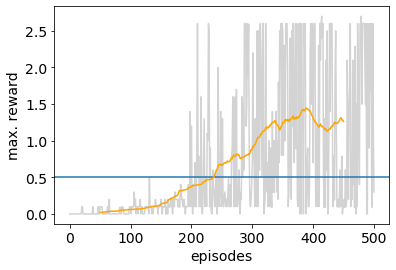

In [33]:
from matplotlib import pyplot as plt
num = 50
average_line = [np.mean(np.asarray(score_table[0])[index-num:index+num]) for index in np.arange(num,len(score_table[0])-num)]
plt.plot(score_table[0], color = "lightgray")
plt.axhline(y=0.5)
plt.plot(np.arange(num, len(score_table[0])-num,1), average_line, color = "orange")
plt.xlabel("episodes", fontsize = 14)
plt.ylabel("max. reward", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig("Result.png")
plt.show()

In [19]:
average_line = [np.mean(np.asarray(score_table[0])[index-num:index+num]) for index in np.arange(num,len(score_table[0])-num)]


In [27]:
agent = agents[0]
a = np.vstack([e.reward for e in agent.memory.memory if e is not None])
b = agent.memory.prios
#any(a)>1

In [29]:
print (np.mean(np.asarray(b)[[np.where(a>0)][0][0]]))
print (np.mean(np.asarray(b)[[np.where(a<0)][0][0]]))
print (np.mean(np.asarray(b)[[np.where(a==0)][0][0]]))

0.009697718545794487
0.013772689165943796
0.0075096900659513705
